In [15]:
import geopandas as geo
import pandas as pd
%config InlineBackend.figure_format ='retina'
from re import sub
from decimal import Decimal
import matplotlib as plt
from shapely.geometry import Point, Polygon
import contextily as cx
import numpy as np

In [17]:
data=pd.read_csv('~/TX_appleseed_lenders_public/data/cleanedpayday(1).csv')
data2=pd.read_csv("~/TX_appleseed_lenders_public/data/evictions_historic_merged.csv")

In [4]:
data2['GEOID_2020'] = data2['GEOID_2020'].astype('str')
data2['JudgementTotal']=data2['judgment_amt']


In [5]:
geometry = [Point(xy) for xy in zip(data['Long'],data['Lat'])]

geo_pts_payday = geo.GeoDataFrame(data,geometry=geometry,crs="EPSG:4326")

In [6]:
pts = data2[['case_number','lon','lat','JudgementTotal']].copy()

In [7]:
pts['Size']=pts['JudgementTotal'].apply(lambda x: np.sqrt(x))

In [8]:
money_df = data2.groupby(by="GEOID_2020").sum()[['JudgementTotal']].reset_index()

In [9]:
geometry = [Point(xy) for xy in zip(pts['lon'],pts['lat'])]

geo_pts = geo.GeoDataFrame(pts,geometry=geometry,crs="EPSG:4326")

In [11]:
gdf = geo.read_file('~/TX_appleseed_lenders_public/shapefiles/PVS_21_v2_bg_481131.shp')
gdf['GEOID']=gdf['BLKGRPID'].apply(lambda x: x[:-1])

In [12]:
df = pd.merge(money_df,gdf, left_on='GEOID_2020', right_on='GEOID', how='right')
gdf = geo.GeoDataFrame(df[['JudgementTotal','GEOID','geometry']])

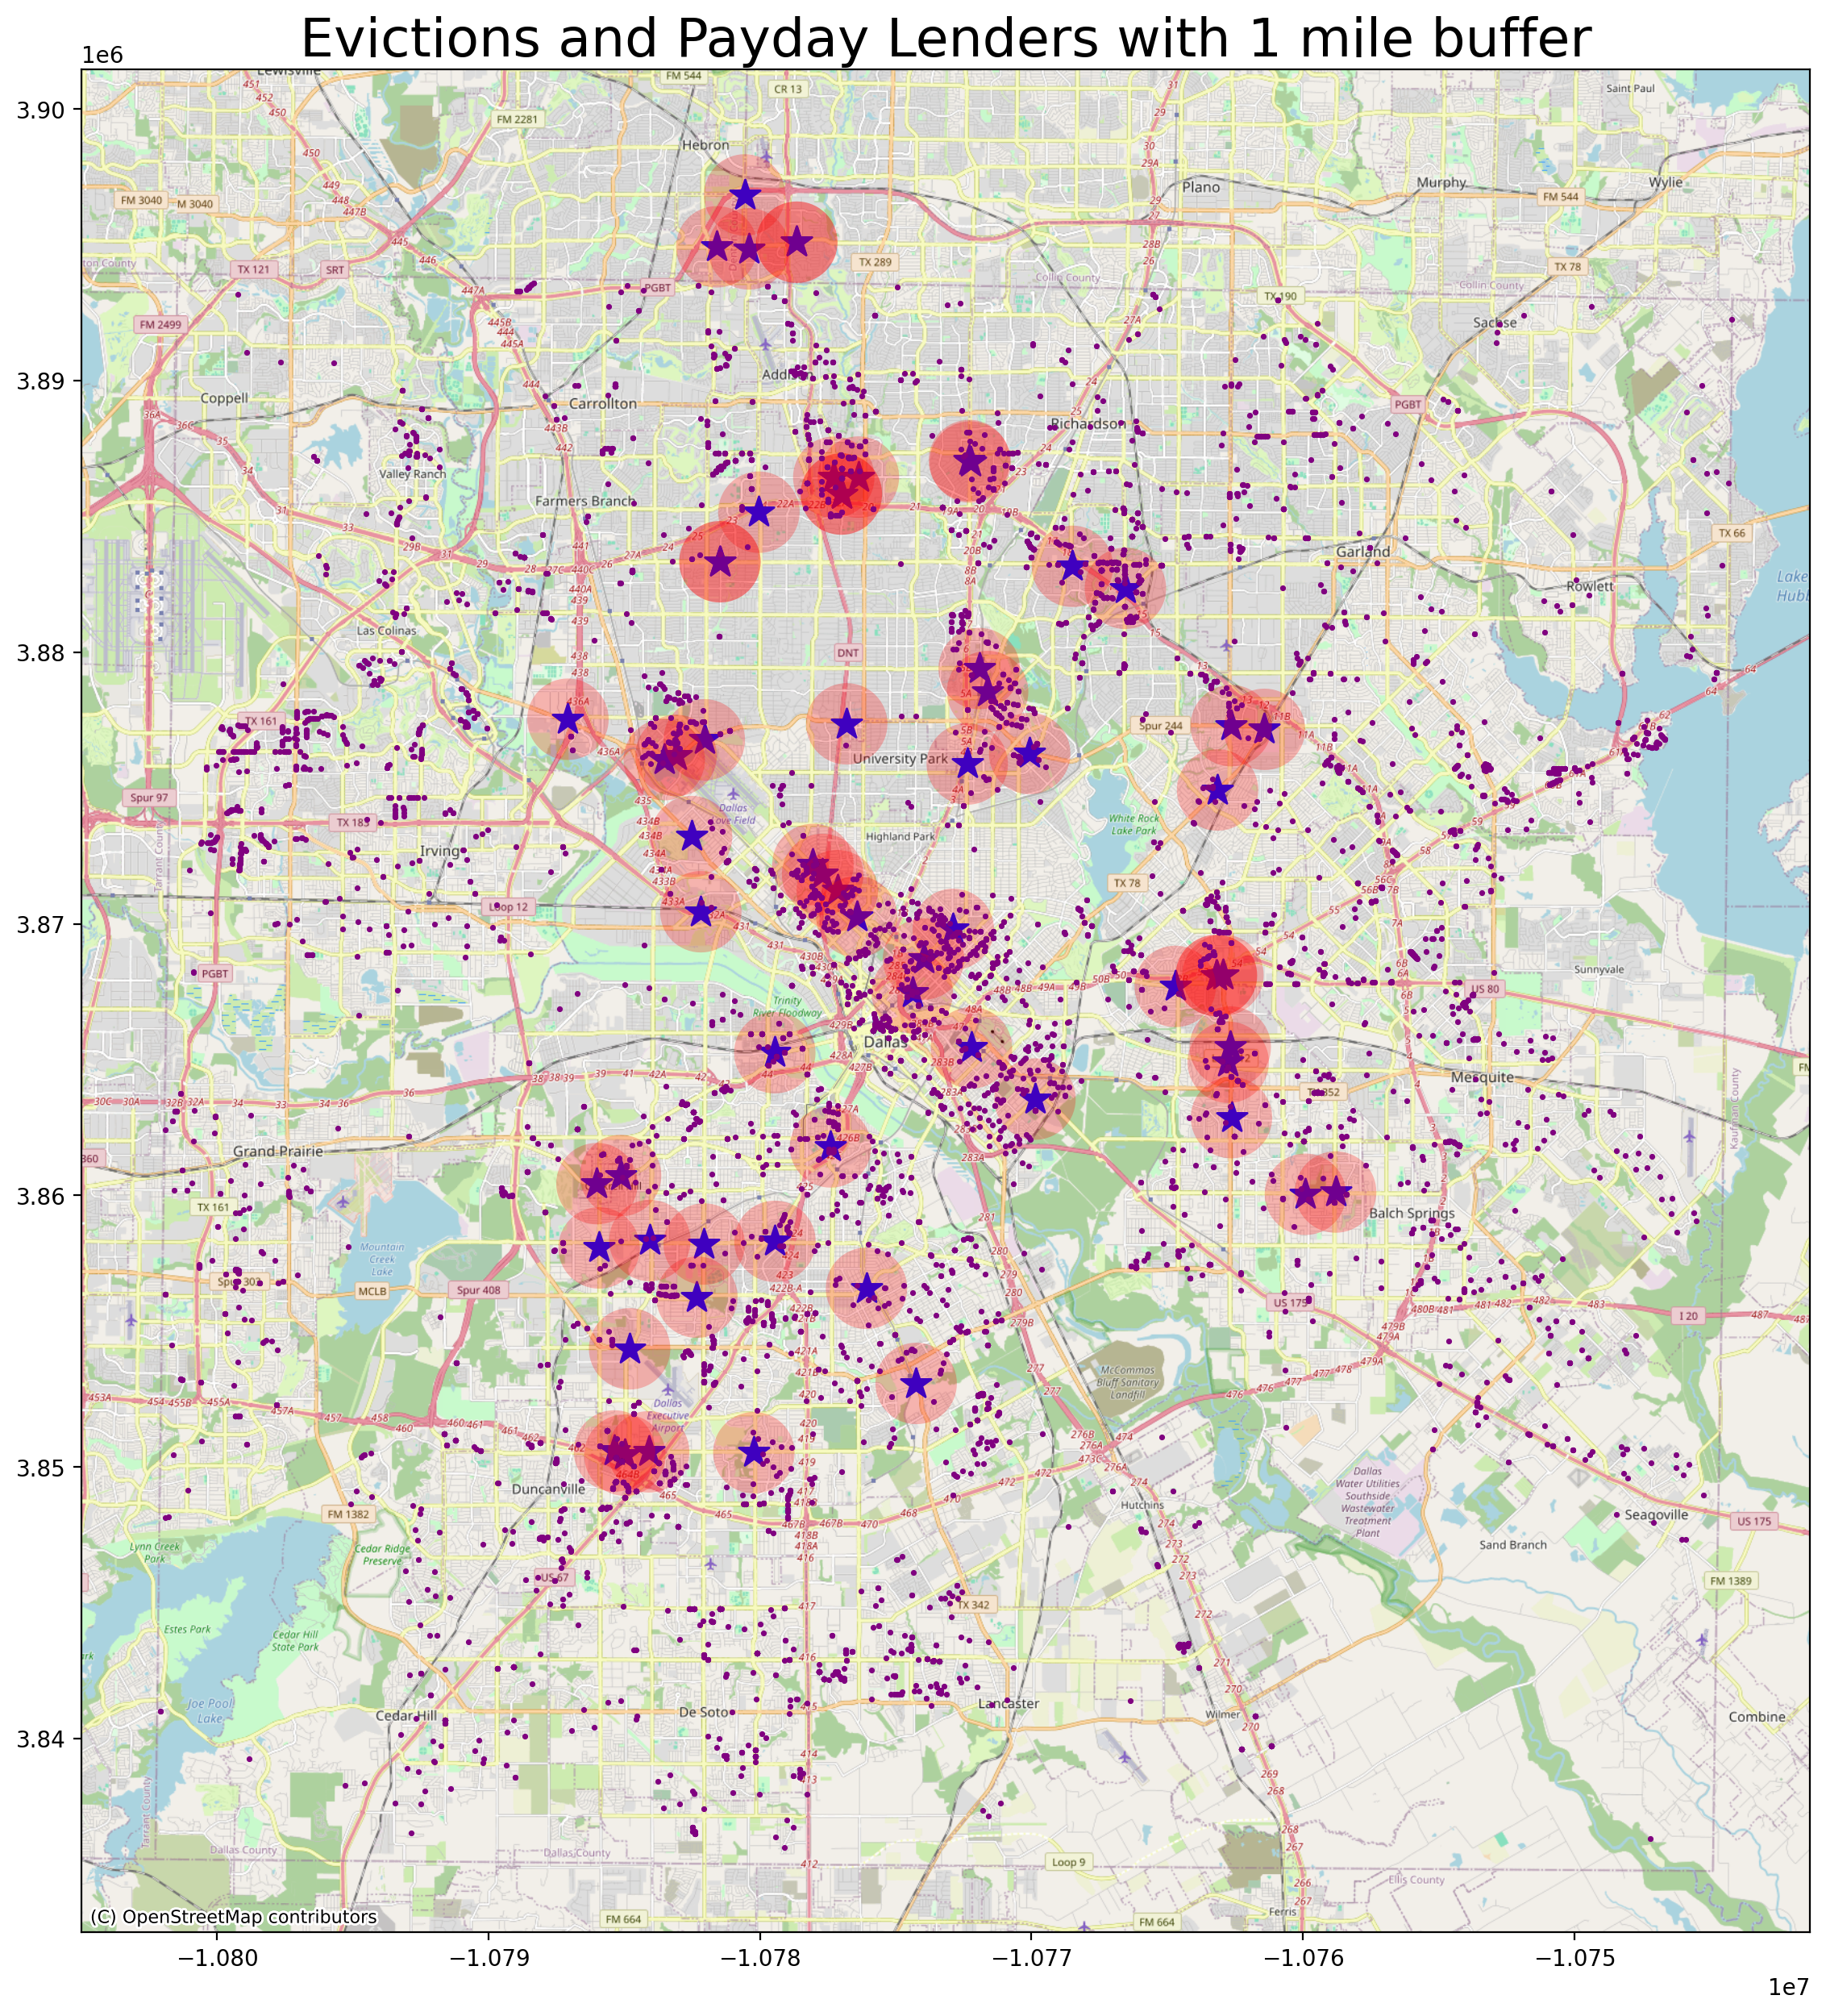

In [16]:
geo_pts_wm_payday = geo_pts_payday.to_crs(epsg=3857)
geo_pts_wm = geo_pts.to_crs(epsg=3857)
buffer = geo_pts_wm_payday.buffer(1500)
ax = geo_pts_wm_payday.plot(marker='*', color='blue', markersize=200, alpha=1,legend=True, figsize=(15,15))
buffer.plot(ax=ax,color='red',alpha=.25)
geo_pts_wm.plot(ax=ax, marker='.', color='purple', markersize=10)

cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik, zoom=14)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik, zoom=12)

ax.set_title('Evictions and Payday Lenders with 1 mile buffer', fontsize=24)
ax.figure.savefig("../results/bufferedlenderswevictions.png", dpi=200, bbox_inches="tight")